## PHYS-253 

## Homework 3

Handed out: Monday, April 1, 2024

**Due: 4.59 pm; Monday, April 8, 2024**

__________________________________________________________________________________________________________________________

### Problem: Predict financial stock prices 

I. In this problem, you will choose a financial stock (of your preference) to make 

a) a next-day prediction. 

b) a seven-day prediction.

You may construct as many NNs as you wish to improve performance, but you must do all models presented in the lecture's notebook (baseline, linear, SimpleRNN, Deep RNNs, LSTM, GRU, bidirectional)

You may use the code presented in the relevant Notebook (which you used in class) to get daily stock price data from YahooFinancials, and adapt code presented in the lectures' notebooks. 

Show all your work and compare your predictions to the next-day (seven-days) actual price(s)!

II. When using RNNs, it is generally not necessary to detrend and deseasonalize. However, removing trend and seasonality may improve performance in some cases (since the model will not have to learn the trend or the seasonality).

Repeat the work you did in part I, but for the stock price returns data (that is, the daily percentage data).

Compare the predictions and accuracies of these two approaches (of Part I on stock price data and of Part II on stock price returns data).

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import os
import numpy as np
import pandas as pd
from zipfile import ZipFile
from tensorflow import keras
from tensorflow import random
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from yahoofinancials import YahooFinancials
from datetime import datetime

**IMPORTANT**

The Disney Stock Predictions plots display the "True Future" trending line which should have been renamed to Historical Data but unfortunately did not have the time to rerun everything again. Then depending on what predictions where needed, there are either 1 day predictions (1 dot) or 7 days predictions (7 dots). 

# Part A

In [9]:
np.random.seed(42)
random.set_seed(42)

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = delta or 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        plt.plot(range(future, future + len(val)) if i else time_steps, val.flatten() if not i else val, marker[i], markersize=10, label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()

def retrieve_stock_data(ticker, start, end):
    json = YahooFinancials(ticker).get_historical_price_data(start, end, "daily")
    df = pd.DataFrame(columns=["open","close","adjclose"])
    for row in json[ticker]["prices"]:
        date = datetime.fromisoformat(row["formatted_date"])
        df.loc[date] = [row["open"], row["close"], row["adjclose"]]
    df.index.name = "date"
    return df

## Generate Data and do the necessary preprocessing.

In [10]:
Disney = retrieve_stock_data("DIS", "2020-01-01", "2024-01-01")

Disney.dropna(inplace=True)       # just in case

num_train_samples = int(0.5 * len(Disney))
num_val_samples = int(0.25 * len(Disney))
num_test_samples = len(Disney) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

mean = Disney[:num_train_samples].mean(axis=0)
Disney -= mean
std = Disney[:num_train_samples].std(axis=0)
Disney /= std

num_train_samples: 503
num_val_samples: 251
num_test_samples: 252


## All the models

**Basic Machine Learning Model**

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(14, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("disney_dense.keras", save_best_only=True)
]
model.compile(optimizer="sgd", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=80,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("disney_dense.keras")

test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/80
2/2 [==============================] - 1s 193ms/step - loss: 0.7208 - mae: 0.7467 - val_loss: 1.2338 - val_mae: 0.9790
Epoch 2/80
2/2 [==============================] - 0s 96ms/step - loss: 0.4957 - mae: 0.6192 - val_loss: 0.8130 - val_mae: 0.7920
Epoch 3/80
2/2 [==============================] - 0s 77ms/step - loss: 0.3451 - mae: 0.5158 - val_loss: 0.5391 - val_mae: 0.6425
Epoch 4/80
2/2 [==============================] - 0s 79ms/step - loss: 0.2414 - mae: 0.4296 - val_loss: 0.3602 - val_mae: 0.5230
Epoch 5/80
2/2 [==============================] - 0s 73ms/step - loss: 0.1710 - mae: 0.3603 - val_loss: 0.2439 - val_mae: 0.4290
Epoch 6/80
2/2 [==============================] - 0s 77ms/step - loss: 0.1229 - mae: 0.3028 - val_loss: 0.1690 - val_mae: 0.3559
Epoch 7/80
2/2 [==============================] - 0s 76ms/step - loss: 0.0899 - mae: 0.2563 - val_loss: 0.1192 - val_mae: 0.2984
Epoch 8/80
2/2 [==============================] - 0s 82ms/step - loss: 0.0667 - mae: 0.2179 - va

1/1 [==============================] - 0s 197ms/step


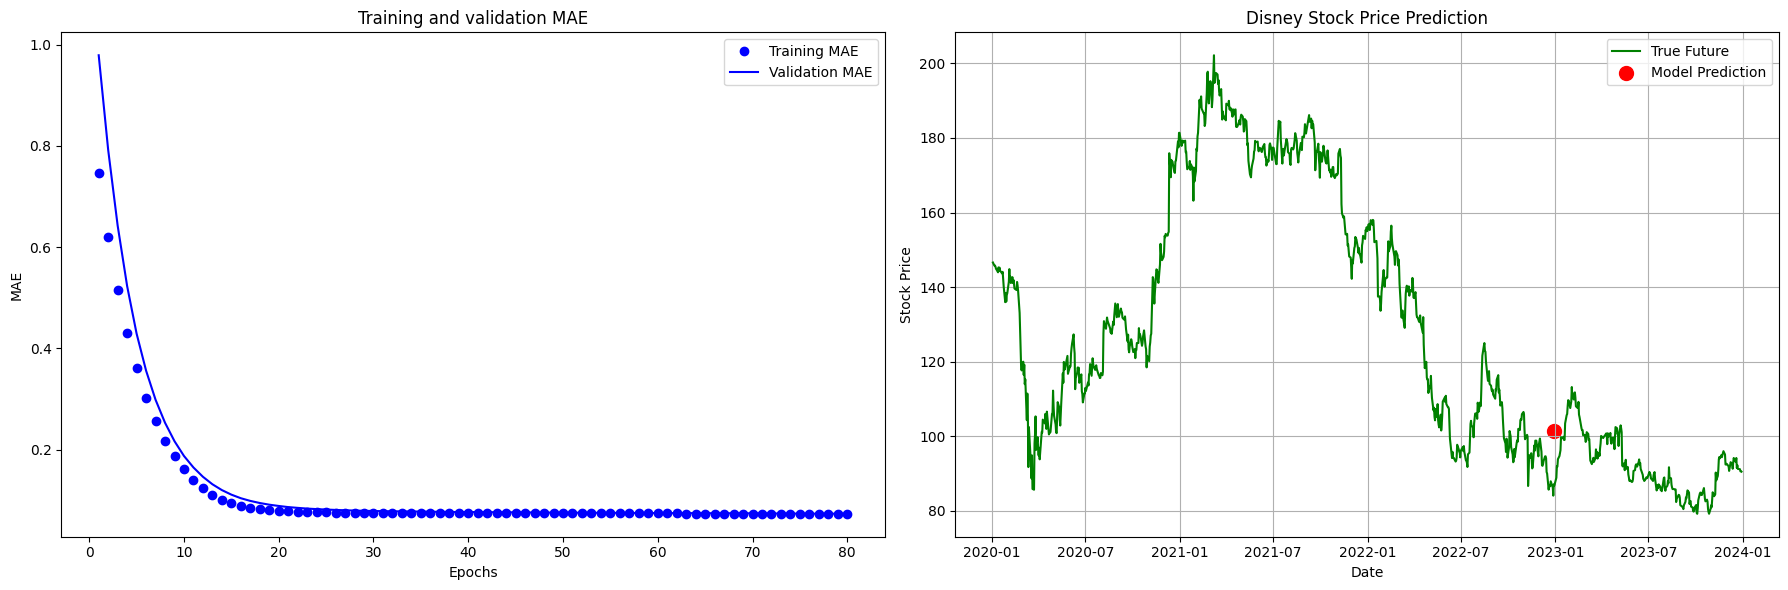

In [17]:
predictions = model.predict(test_dataset)

predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 1)  
axs[1].scatter(raw_data.index[-len(predictions):][prediction_indices], 
            predictions[prediction_indices], 
            label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


**Linear**

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs) 
x = layers.Dense(14, activation='relu')(x)  
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("disney_linear.keras", save_best_only=True)
]

model.compile(optimizer="sgd", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=80, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("disney_linear.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/80
2/2 [==============================] - 1s 158ms/step - loss: 0.8747 - mae: 0.8150 - val_loss: 1.8542 - val_mae: 1.2012
Epoch 2/80
2/2 [==============================] - 0s 108ms/step - loss: 0.6976 - mae: 0.7277 - val_loss: 1.4672 - val_mae: 1.0669
Epoch 3/80
2/2 [==============================] - 0s 84ms/step - loss: 0.5569 - mae: 0.6493 - val_loss: 1.1618 - val_mae: 0.9478
Epoch 4/80
2/2 [==============================] - 0s 80ms/step - loss: 0.4439 - mae: 0.5780 - val_loss: 0.9195 - val_mae: 0.8415
Epoch 5/80
2/2 [==============================] - 0s 72ms/step - loss: 0.3536 - mae: 0.5153 - val_loss: 0.7268 - val_mae: 0.7466
Epoch 6/80
2/2 [==============================] - 0s 74ms/step - loss: 0.2815 - mae: 0.4589 - val_loss: 0.5740 - val_mae: 0.6620
Epoch 7/80
2/2 [==============================] - 0s 78ms/step - loss: 0.2239 - mae: 0.4080 - val_loss: 0.4528 - val_mae: 0.5865
Epoch 8/80
2/2 [==============================] - 0s 72ms/step - loss: 0.1778 - mae: 0.3616 - v

1/1 [==============================] - 0s 120ms/step


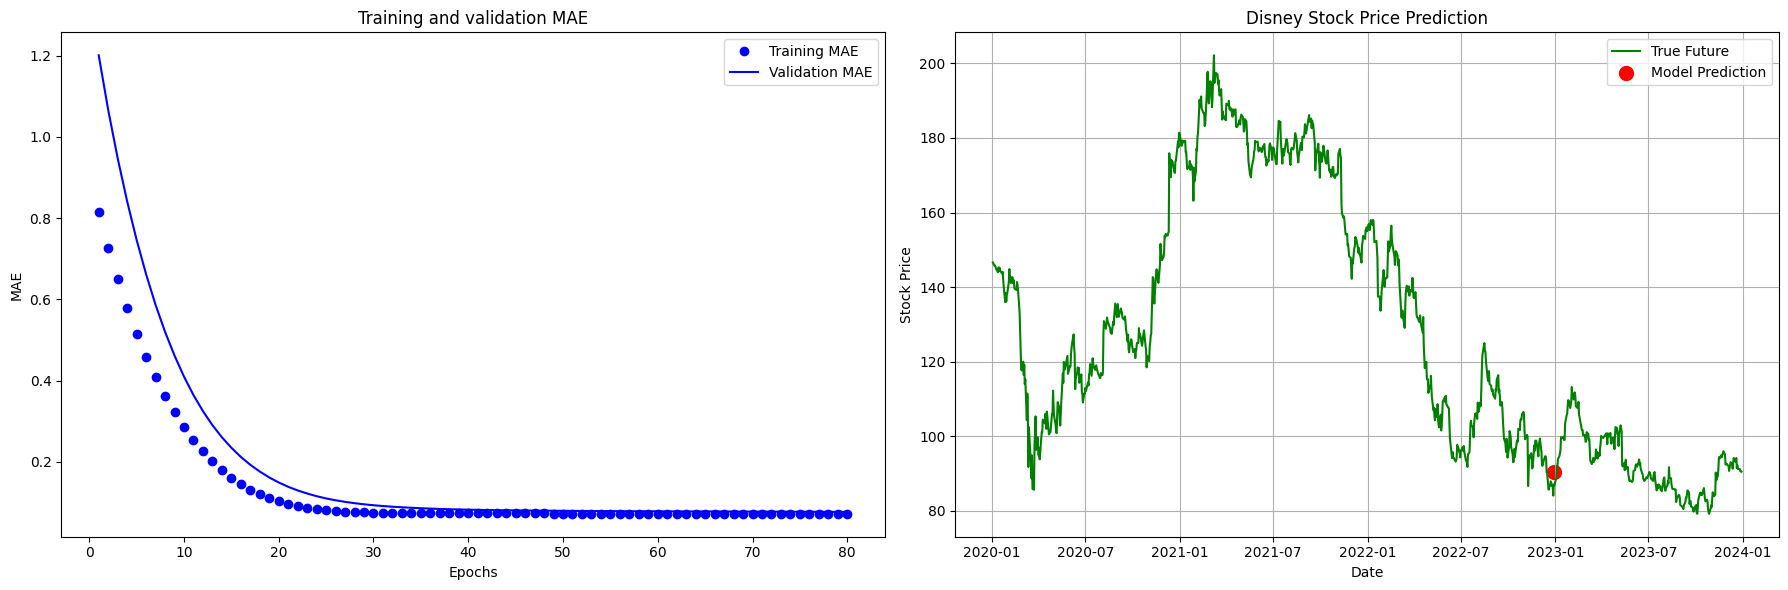

In [19]:
predictions = model.predict(test_dataset)

predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 1) 
axs[1].scatter(raw_data.index[-len(predictions):][prediction_indices], 
            predictions[prediction_indices], 
            label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

**A simple LSTM-based model** (A first recurent baseline)

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(14)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("disney_lstm.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=70,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("disney_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/70
2/2 [==============================] - 3s 477ms/step - loss: 0.6954 - mae: 0.7372 - val_loss: 1.5242 - val_mae: 1.0833
Epoch 2/70
2/2 [==============================] - 0s 73ms/step - loss: 0.6632 - mae: 0.7189 - val_loss: 1.4712 - val_mae: 1.0637
Epoch 3/70
2/2 [==============================] - 0s 77ms/step - loss: 0.6408 - mae: 0.7063 - val_loss: 1.4276 - val_mae: 1.0473
Epoch 4/70
2/2 [==============================] - 0s 83ms/step - loss: 0.6220 - mae: 0.6955 - val_loss: 1.3890 - val_mae: 1.0325
Epoch 5/70
2/2 [==============================] - 0s 78ms/step - loss: 0.6053 - mae: 0.6858 - val_loss: 1.3547 - val_mae: 1.0192
Epoch 6/70
2/2 [==============================] - 0s 79ms/step - loss: 0.5898 - mae: 0.6765 - val_loss: 1.3217 - val_mae: 1.0063
Epoch 7/70
2/2 [==============================] - 0s 80ms/step - loss: 0.5754 - mae: 0.6680 - val_loss: 1.2907 - val_mae: 0.9940
Epoch 8/70
2/2 [==============================] - 0s 83ms/step - loss: 0.5616 - mae: 0.6595 - va

1/1 [==============================] - 1s 794ms/step


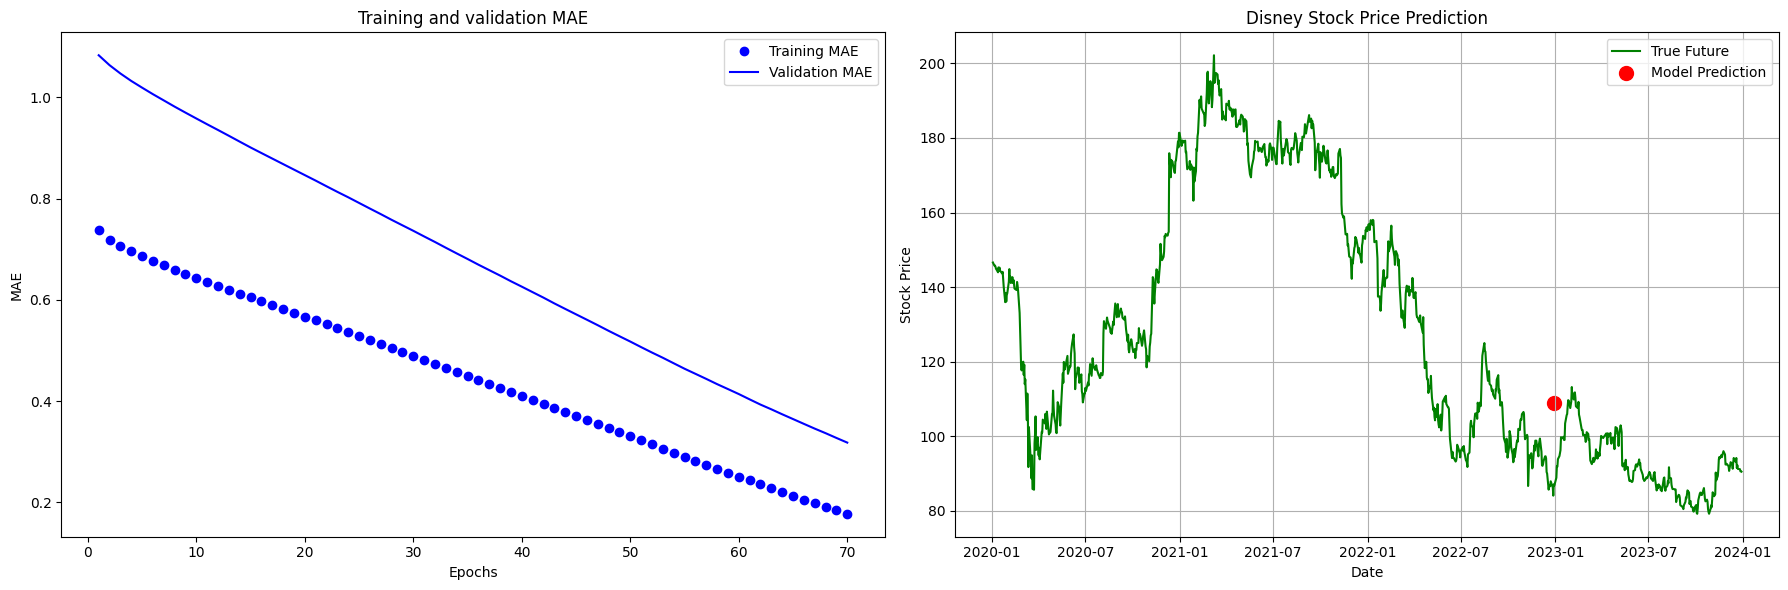

In [21]:
predictions = model.predict(test_dataset)

predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 1) 
axs[1].scatter(raw_data.index[-len(predictions):][prediction_indices], 
            predictions[prediction_indices], 
            label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Implementation of a simple RNN**

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.SimpleRNN(14)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("disney_lstm.keras", save_best_only=True)
]

model.compile(optimizer="sgd", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=70,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("disney_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/70
2/2 [==============================] - 2s 388ms/step - loss: 3.4378 - mae: 1.6929 - val_loss: 4.0539 - val_mae: 1.8039
Epoch 2/70
2/2 [==============================] - 0s 115ms/step - loss: 1.9613 - mae: 1.2706 - val_loss: 2.5353 - val_mae: 1.4159
Epoch 3/70
2/2 [==============================] - 0s 106ms/step - loss: 1.1382 - mae: 0.9603 - val_loss: 1.6319 - val_mae: 1.1251
Epoch 4/70
2/2 [==============================] - 0s 102ms/step - loss: 0.6700 - mae: 0.7235 - val_loss: 1.0832 - val_mae: 0.9058
Epoch 5/70
2/2 [==============================] - 0s 101ms/step - loss: 0.4014 - mae: 0.5484 - val_loss: 0.7423 - val_mae: 0.7390
Epoch 6/70
2/2 [==============================] - 0s 112ms/step - loss: 0.2454 - mae: 0.4168 - val_loss: 0.5261 - val_mae: 0.6119
Epoch 7/70
2/2 [==============================] - 0s 108ms/step - loss: 0.1544 - mae: 0.3176 - val_loss: 0.3866 - val_mae: 0.5156
Epoch 8/70
2/2 [==============================] - 0s 100ms/step - loss: 0.1011 - mae: 0.24

1/1 [==============================] - 0s 346ms/step


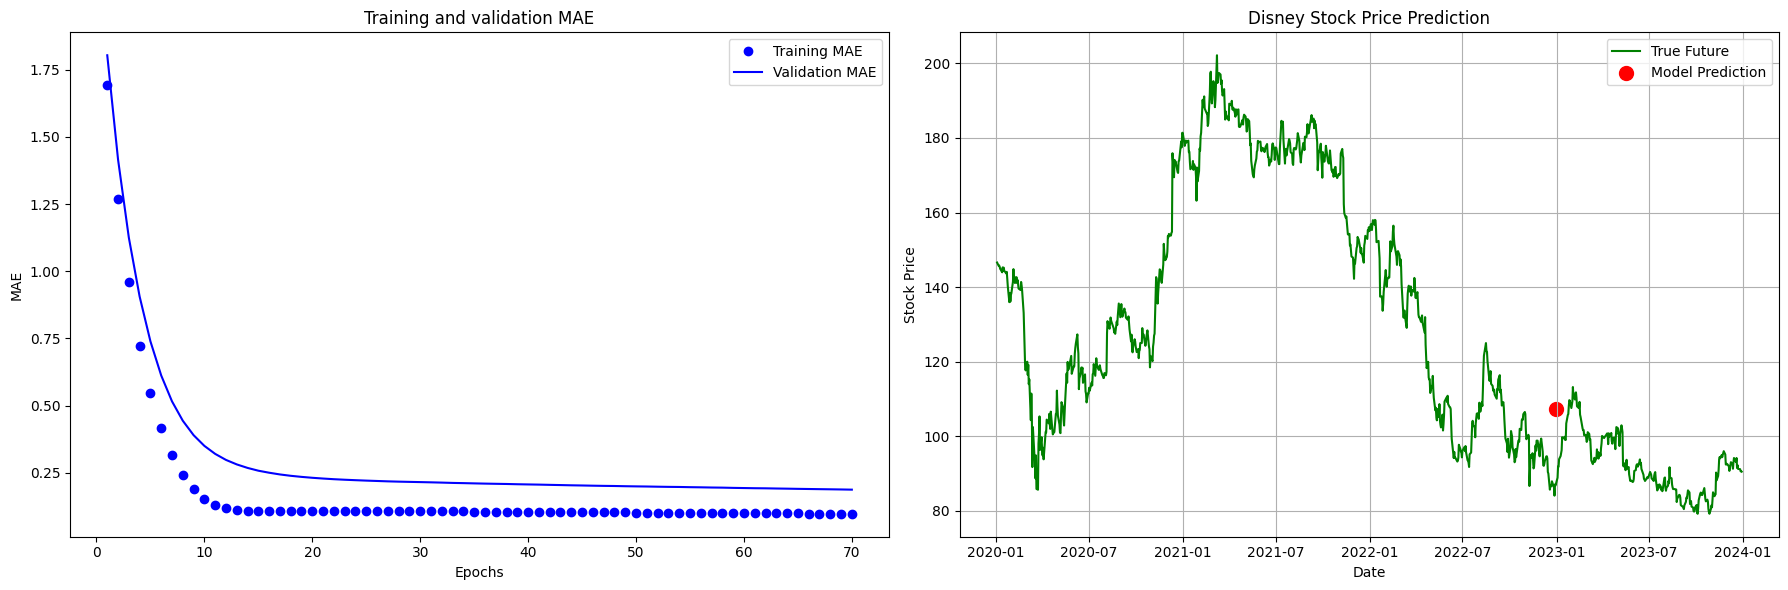

In [23]:
predictions = model.predict(test_dataset)

predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 1)  
axs[1].scatter(raw_data.index[-len(predictions):][prediction_indices], 
            predictions[prediction_indices], 
            label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Deep RNN**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("disney_deep_rnn.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=70,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("disney_deep_rnn.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/70
2/2 [==============================] - 3s 631ms/step - loss: 0.1631 - mae: 0.3162 - val_loss: 0.4780 - val_mae: 0.5683
Epoch 2/70
2/2 [==============================] - 0s 118ms/step - loss: 0.1269 - mae: 0.2579 - val_loss: 0.4521 - val_mae: 0.5498
Epoch 3/70
2/2 [==============================] - 0s 104ms/step - loss: 0.1144 - mae: 0.2364 - val_loss: 0.4384 - val_mae: 0.5417
Epoch 4/70
2/2 [==============================] - 0s 116ms/step - loss: 0.1075 - mae: 0.2249 - val_loss: 0.4284 - val_mae: 0.5362
Epoch 5/70
2/2 [==============================] - 0s 116ms/step - loss: 0.1031 - mae: 0.2183 - val_loss: 0.4217 - val_mae: 0.5331
Epoch 6/70
2/2 [==============================] - 0s 115ms/step - loss: 0.1001 - mae: 0.2140 - val_loss: 0.4160 - val_mae: 0.5308
Epoch 7/70
2/2 [==============================] - 0s 123ms/step - loss: 0.0979 - mae: 0.2116 - val_loss: 0.4120 - val_mae: 0.5294
Epoch 8/70
2/2 [==============================] - 0s 117ms/step - loss: 0.0963 - mae: 0.21

1/1 [==============================] - 1s 622ms/step


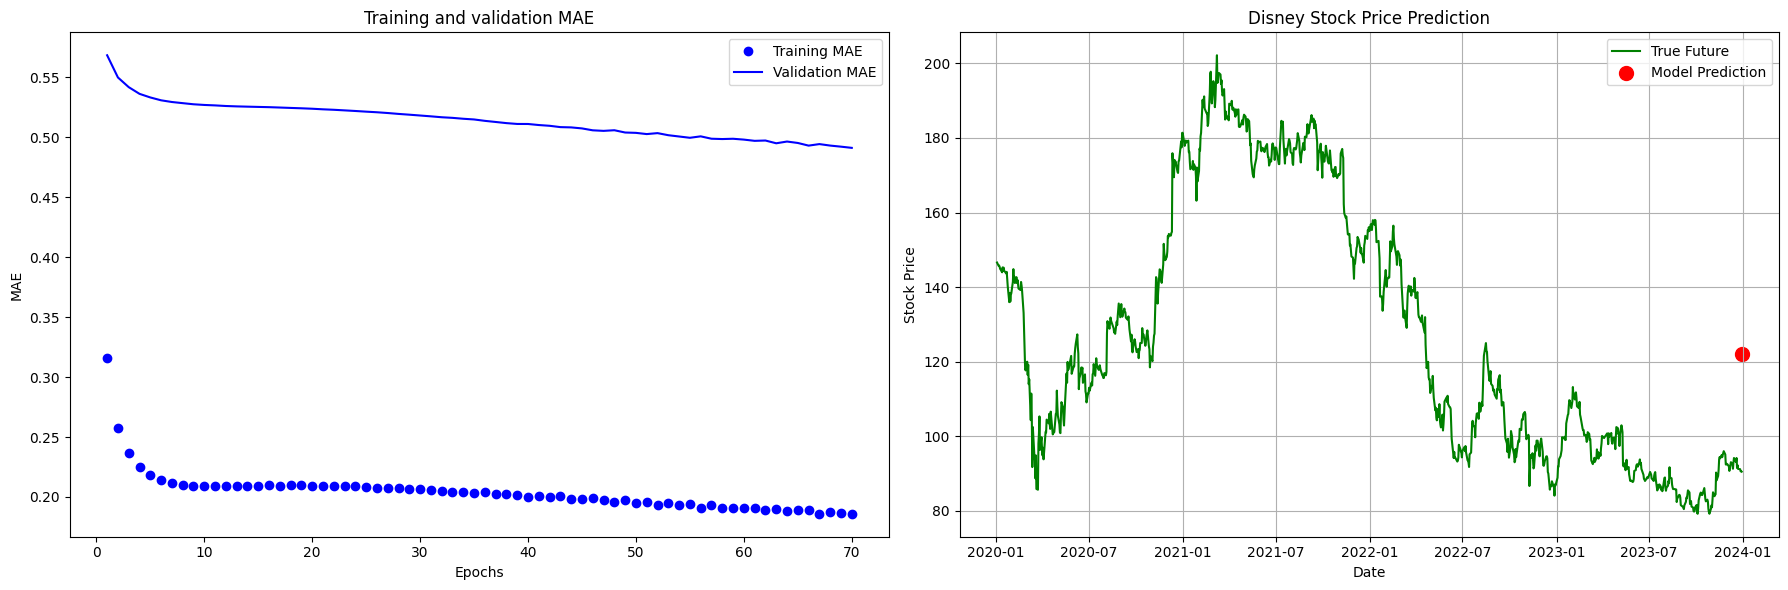

In [25]:
import matplotlib.pyplot as plt

predictions = model.predict(test_dataset)
predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 1) 
axs[1].scatter(raw_data.index[-len(prediction_indices):], 
               predictions[prediction_indices], 
               label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()


**Stacked GRU model**

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.3, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.3)(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("Disney_stacked_gru_dropout.keras", save_best_only=True)
]

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=80,  
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("Disney_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/80
2/2 [==============================] - 7s 922ms/step - loss: 1.0166 - mae: 0.9040 - val_loss: 1.9310 - val_mae: 1.2318
Epoch 2/80
2/2 [==============================] - 0s 132ms/step - loss: 0.9635 - mae: 0.8794 - val_loss: 1.8302 - val_mae: 1.1995
Epoch 3/80
2/2 [==============================] - 0s 115ms/step - loss: 0.9096 - mae: 0.8548 - val_loss: 1.7230 - val_mae: 1.1638
Epoch 4/80
2/2 [==============================] - 0s 128ms/step - loss: 0.8496 - mae: 0.8266 - val_loss: 1.6170 - val_mae: 1.1274
Epoch 5/80
2/2 [==============================] - 0s 135ms/step - loss: 0.8023 - mae: 0.8017 - val_loss: 1.5092 - val_mae: 1.0891
Epoch 6/80
2/2 [==============================] - 0s 125ms/step - loss: 0.7533 - mae: 0.7768 - val_loss: 1.4056 - val_mae: 1.0510
Epoch 7/80
2/2 [==============================] - 0s 123ms/step - loss: 0.6947 - mae: 0.7458 - val_loss: 1.3029 - val_mae: 1.0119
Epoch 8/80
2/2 [==============================] - 0s 131ms/step - loss: 0.6425 - mae: 0.71

1/1 [==============================] - 1s 862ms/step


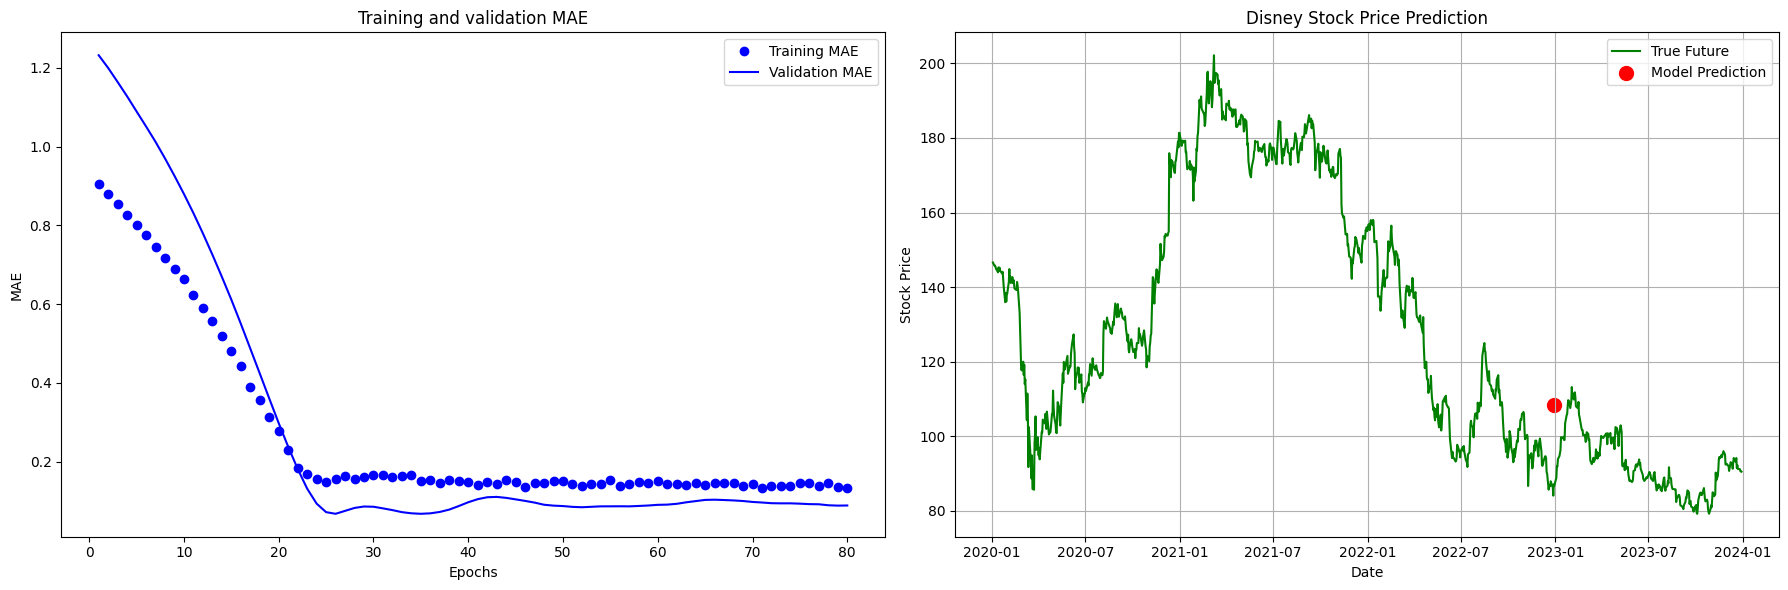

In [27]:
predictions = model.predict(test_dataset)

predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 1)  
axs[1].scatter(raw_data.index[-len(predictions):][prediction_indices], 
            predictions[prediction_indices], 
            label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Bidirectional RNNs** (Specifically LSTM)

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(15))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("Disney_bidirect_rnn.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=80,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("Disney_bidirect_rnn.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/80
2/2 [==============================] - 6s 1s/step - loss: 1.3429 - mae: 1.0461 - val_loss: 2.3836 - val_mae: 1.3742
Epoch 2/80
2/2 [==============================] - 0s 115ms/step - loss: 1.3099 - mae: 1.0330 - val_loss: 2.3380 - val_mae: 1.3610
Epoch 3/80
2/2 [==============================] - 0s 111ms/step - loss: 1.2789 - mae: 1.0204 - val_loss: 2.2933 - val_mae: 1.3480
Epoch 4/80
2/2 [==============================] - 0s 123ms/step - loss: 1.2473 - mae: 1.0075 - val_loss: 2.2482 - val_mae: 1.3347
Epoch 5/80
2/2 [==============================] - 0s 116ms/step - loss: 1.2160 - mae: 0.9945 - val_loss: 2.2026 - val_mae: 1.3211
Epoch 6/80
2/2 [==============================] - 0s 124ms/step - loss: 1.1855 - mae: 0.9818 - val_loss: 2.1588 - val_mae: 1.3080
Epoch 7/80
2/2 [==============================] - 0s 131ms/step - loss: 1.1558 - mae: 0.9692 - val_loss: 2.1137 - val_mae: 1.2942
Epoch 8/80
2/2 [==============================] - 0s 117ms/step - loss: 1.1264 - mae: 0.9565 

1/1 [==============================] - 1s 1s/step


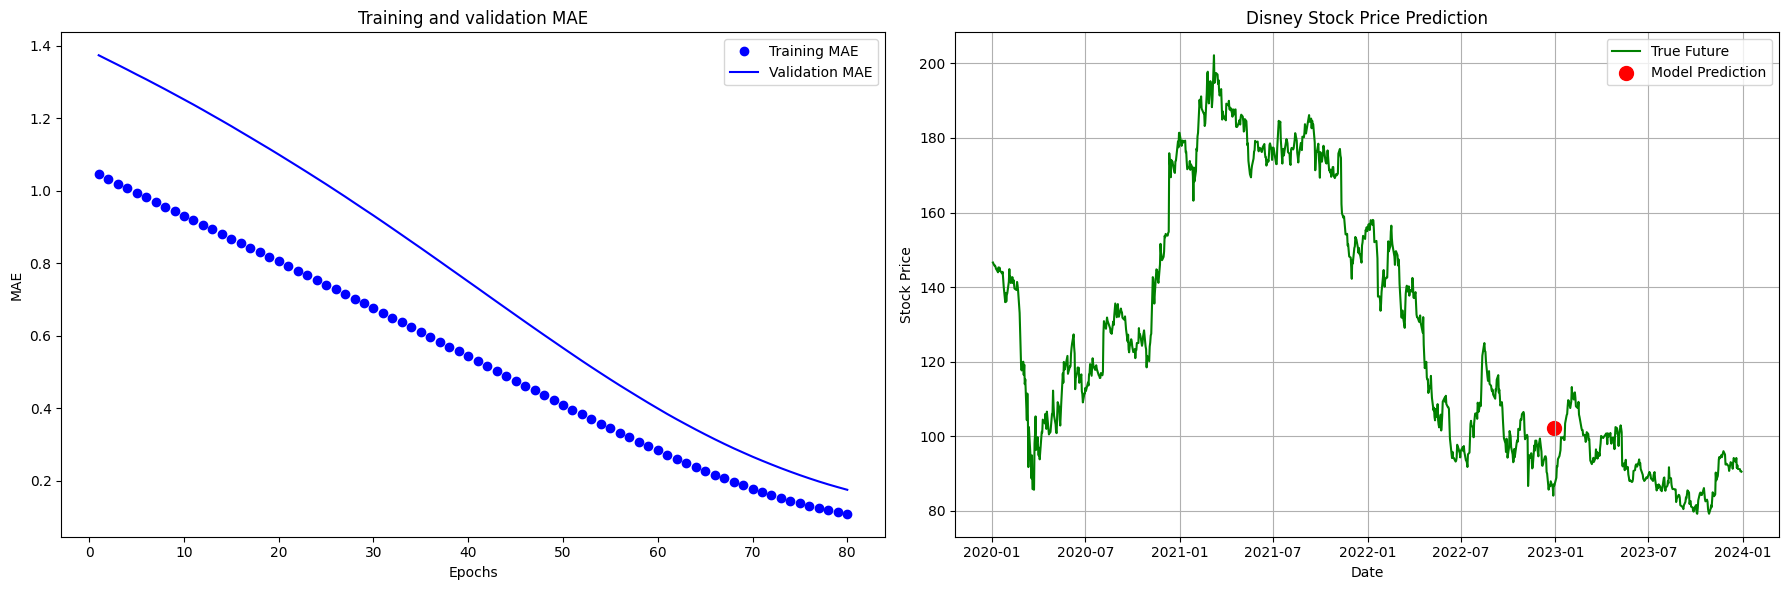

In [29]:
predictions = model.predict(test_dataset)

predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 1)  
axs[1].scatter(raw_data.index[-len(predictions):][prediction_indices], 
            predictions[prediction_indices], 
            label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Part B

## Same process as before

In [100]:
def retrieve_stock_data(ticker, start, end):
    json = YahooFinancials(ticker).get_historical_price_data(start, end, "daily")
    df = pd.DataFrame(columns=["open","close","adjclose"])
    for row in json[ticker]["prices"]:
        date = datetime.fromisoformat(row["formatted_date"])
        df.loc[date] = [row["open"], row["close"], row["adjclose"]]
    df.index.name = "date"
    return df

In [30]:
np.random.seed(42)
random.set_seed(42)

Disney = retrieve_stock_data("DIS", "2020-01-01", "2024-01-01")

Disney.dropna(inplace=True)       # just in case

num_train_samples = int(0.5 * len(Disney))
num_val_samples = int(0.25 * len(Disney))
num_test_samples = len(Disney) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

mean = Disney[:num_train_samples].mean(axis=0)
Disney -= mean
std = Disney[:num_train_samples].std(axis=0)
Disney /= std

sampling_rate = 1
sequence_length = 1
future = 7
delay = sampling_rate * (sequence_length + future - 1)
batch_size = 256

raw_data = Disney

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=raw_data[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=raw_data[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=raw_data[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


num_train_samples: 503
num_val_samples: 251
num_test_samples: 252


## Models

**Basic Machine Learning Model**

In [32]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(13, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("disney_dense.keras", save_best_only=True)
]
model.compile(optimizer="sgd", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=80,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("disney_dense.keras")

test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/80
2/2 [==============================] - 1s 273ms/step - loss: 1.8783 - mae: 0.9278 - val_loss: 5.9830 - val_mae: 2.1705
Epoch 2/80
2/2 [==============================] - 0s 116ms/step - loss: 1.5211 - mae: 0.8338 - val_loss: 4.9892 - val_mae: 1.9771
Epoch 3/80
2/2 [==============================] - 0s 116ms/step - loss: 1.2616 - mae: 0.7622 - val_loss: 4.2274 - val_mae: 1.8167
Epoch 4/80
2/2 [==============================] - 0s 125ms/step - loss: 1.0639 - mae: 0.7033 - val_loss: 3.6283 - val_mae: 1.6802
Epoch 5/80
2/2 [==============================] - 0s 136ms/step - loss: 0.9099 - mae: 0.6550 - val_loss: 3.1423 - val_mae: 1.5612
Epoch 6/80
2/2 [==============================] - 0s 142ms/step - loss: 0.7860 - mae: 0.6127 - val_loss: 2.7435 - val_mae: 1.4568
Epoch 7/80
2/2 [==============================] - 0s 106ms/step - loss: 0.6844 - mae: 0.5765 - val_loss: 2.4083 - val_mae: 1.3632
Epoch 8/80
2/2 [==============================] - 0s 106ms/step - loss: 0.6001 - mae: 0.54

1/1 [==============================] - 0s 110ms/step


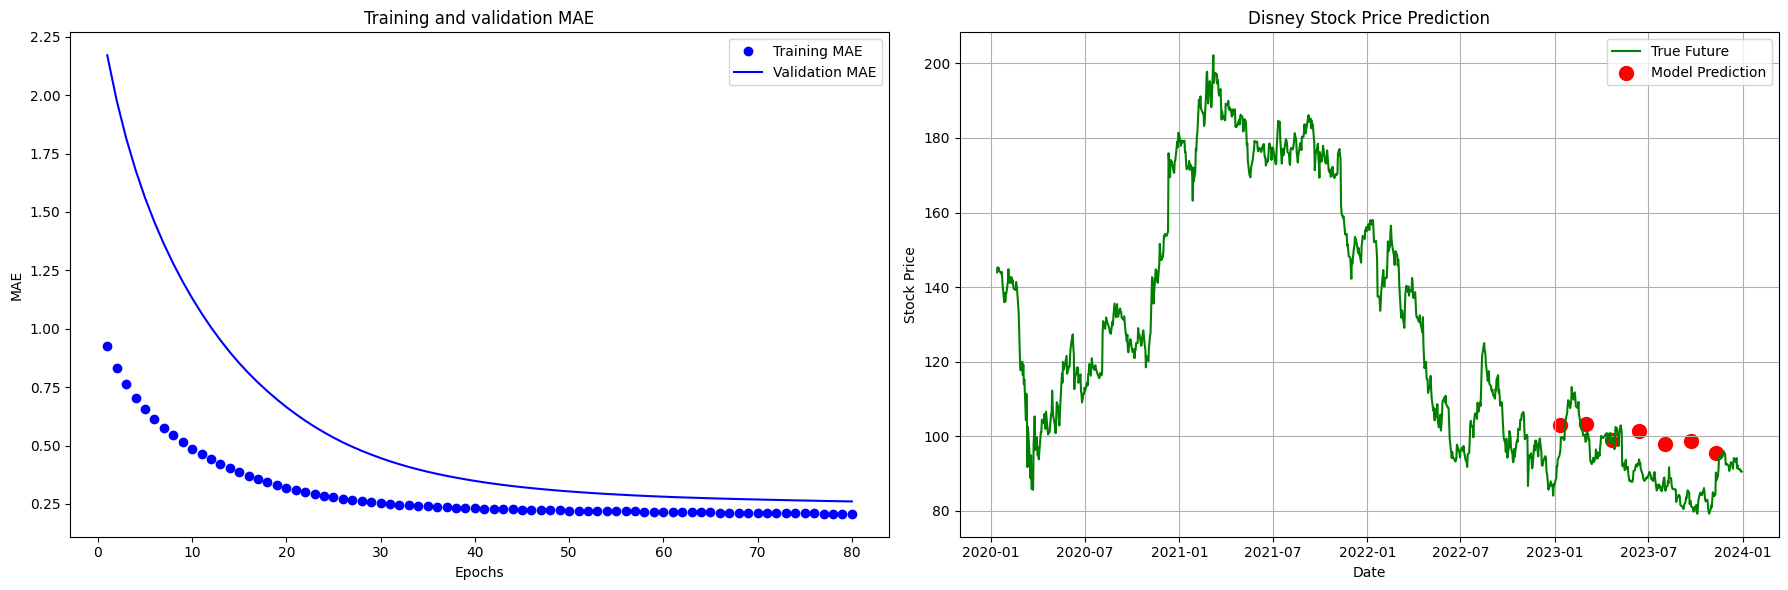

In [34]:
predictions = model.predict(test_dataset)

predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 7) 
axs[1].scatter(raw_data.index[-len(predictions):][prediction_indices], 
            predictions[prediction_indices], 
            label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Linear**

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs) 
x = layers.Dense(15, activation='relu')(x)  
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("disney_linear.keras", save_best_only=True)
]

model.compile(optimizer="sgd", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=80, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("disney_linear.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/80
2/2 [==============================] - 1s 315ms/step - loss: 0.7024 - mae: 0.7487 - val_loss: 1.1041 - val_mae: 0.9438
Epoch 2/80
2/2 [==============================] - 0s 128ms/step - loss: 0.5433 - mae: 0.6556 - val_loss: 0.8414 - val_mae: 0.8237
Epoch 3/80
2/2 [==============================] - 0s 130ms/step - loss: 0.4236 - mae: 0.5769 - val_loss: 0.6494 - val_mae: 0.7226
Epoch 4/80
2/2 [==============================] - 0s 125ms/step - loss: 0.3331 - mae: 0.5094 - val_loss: 0.5068 - val_mae: 0.6368
Epoch 5/80
2/2 [==============================] - 0s 124ms/step - loss: 0.2647 - mae: 0.4503 - val_loss: 0.4001 - val_mae: 0.5642
Epoch 6/80
2/2 [==============================] - 0s 124ms/step - loss: 0.2130 - mae: 0.3994 - val_loss: 0.3210 - val_mae: 0.5042
Epoch 7/80
2/2 [==============================] - 0s 99ms/step - loss: 0.1744 - mae: 0.3573 - val_loss: 0.2621 - val_mae: 0.4552
Epoch 8/80
2/2 [==============================] - 0s 107ms/step - loss: 0.1453 - mae: 0.321

1/1 [==============================] - 0s 189ms/step


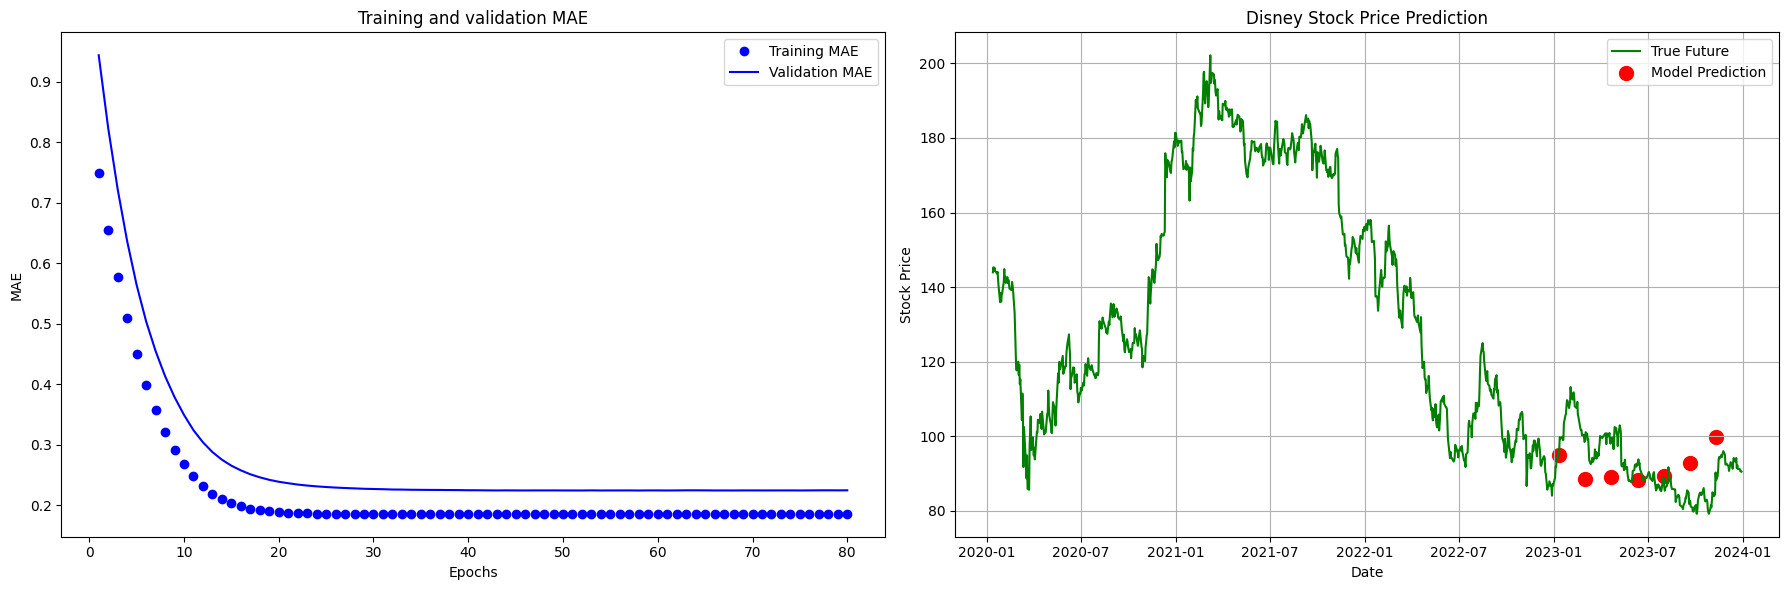

In [36]:
predictions = model.predict(test_dataset)

predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 7) 
axs[1].scatter(raw_data.index[-len(predictions):][prediction_indices], 
            predictions[prediction_indices], 
            label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

**A simple LSTM-based model** (A first recurent baseline)

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(13)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("disney_lstm.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=70,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("disney_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/70
2/2 [==============================] - 3s 717ms/step - loss: 1.0615 - mae: 0.9273 - val_loss: 2.0400 - val_mae: 1.2813
Epoch 2/70
2/2 [==============================] - 0s 104ms/step - loss: 1.0308 - mae: 0.9137 - val_loss: 1.9909 - val_mae: 1.2662
Epoch 3/70
2/2 [==============================] - 0s 107ms/step - loss: 1.0091 - mae: 0.9039 - val_loss: 1.9514 - val_mae: 1.2539
Epoch 4/70
2/2 [==============================] - 0s 109ms/step - loss: 0.9907 - mae: 0.8955 - val_loss: 1.9152 - val_mae: 1.2426
Epoch 5/70
2/2 [==============================] - 0s 102ms/step - loss: 0.9741 - mae: 0.8879 - val_loss: 1.8806 - val_mae: 1.2316
Epoch 6/70
2/2 [==============================] - 0s 110ms/step - loss: 0.9584 - mae: 0.8806 - val_loss: 1.8472 - val_mae: 1.2209
Epoch 7/70
2/2 [==============================] - 0s 112ms/step - loss: 0.9436 - mae: 0.8736 - val_loss: 1.8151 - val_mae: 1.2105
Epoch 8/70
2/2 [==============================] - 0s 103ms/step - loss: 0.9292 - mae: 0.86

1/1 [==============================] - 1s 708ms/step


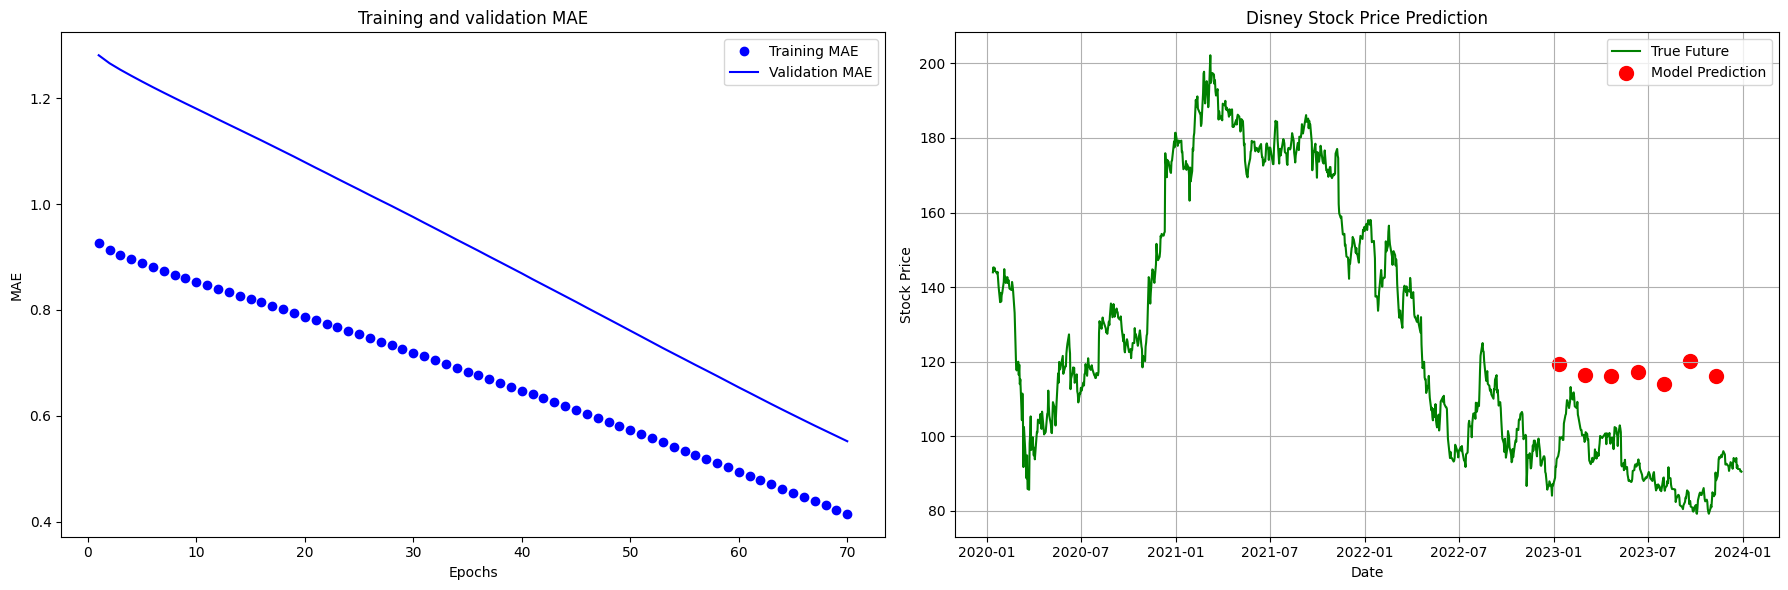

In [38]:
predictions = model.predict(test_dataset)

predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 7)  
axs[1].scatter(raw_data.index[-len(predictions):][prediction_indices], 
            predictions[prediction_indices], 
            label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Implementation of a simple RNN**

In [39]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.SimpleRNN(15)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("disney_lstm.keras", save_best_only=True)
]

model.compile(optimizer="sgd", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=70,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("disney_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/70
2/2 [==============================] - 2s 420ms/step - loss: 0.4823 - mae: 0.6094 - val_loss: 0.8602 - val_mae: 0.8267
Epoch 2/70
2/2 [==============================] - 0s 100ms/step - loss: 0.3250 - mae: 0.4923 - val_loss: 0.6254 - val_mae: 0.7031
Epoch 3/70
2/2 [==============================] - 0s 108ms/step - loss: 0.2268 - mae: 0.4017 - val_loss: 0.4688 - val_mae: 0.6074
Epoch 4/70
2/2 [==============================] - 0s 105ms/step - loss: 0.1660 - mae: 0.3345 - val_loss: 0.3638 - val_mae: 0.5353
Epoch 5/70
2/2 [==============================] - 0s 103ms/step - loss: 0.1284 - mae: 0.2868 - val_loss: 0.2918 - val_mae: 0.4803
Epoch 6/70
2/2 [==============================] - 0s 105ms/step - loss: 0.1051 - mae: 0.2528 - val_loss: 0.2424 - val_mae: 0.4380
Epoch 7/70
2/2 [==============================] - 0s 104ms/step - loss: 0.0908 - mae: 0.2305 - val_loss: 0.2077 - val_mae: 0.4050
Epoch 8/70
2/2 [==============================] - 0s 108ms/step - loss: 0.0821 - mae: 0.21

1/1 [==============================] - 0s 343ms/step


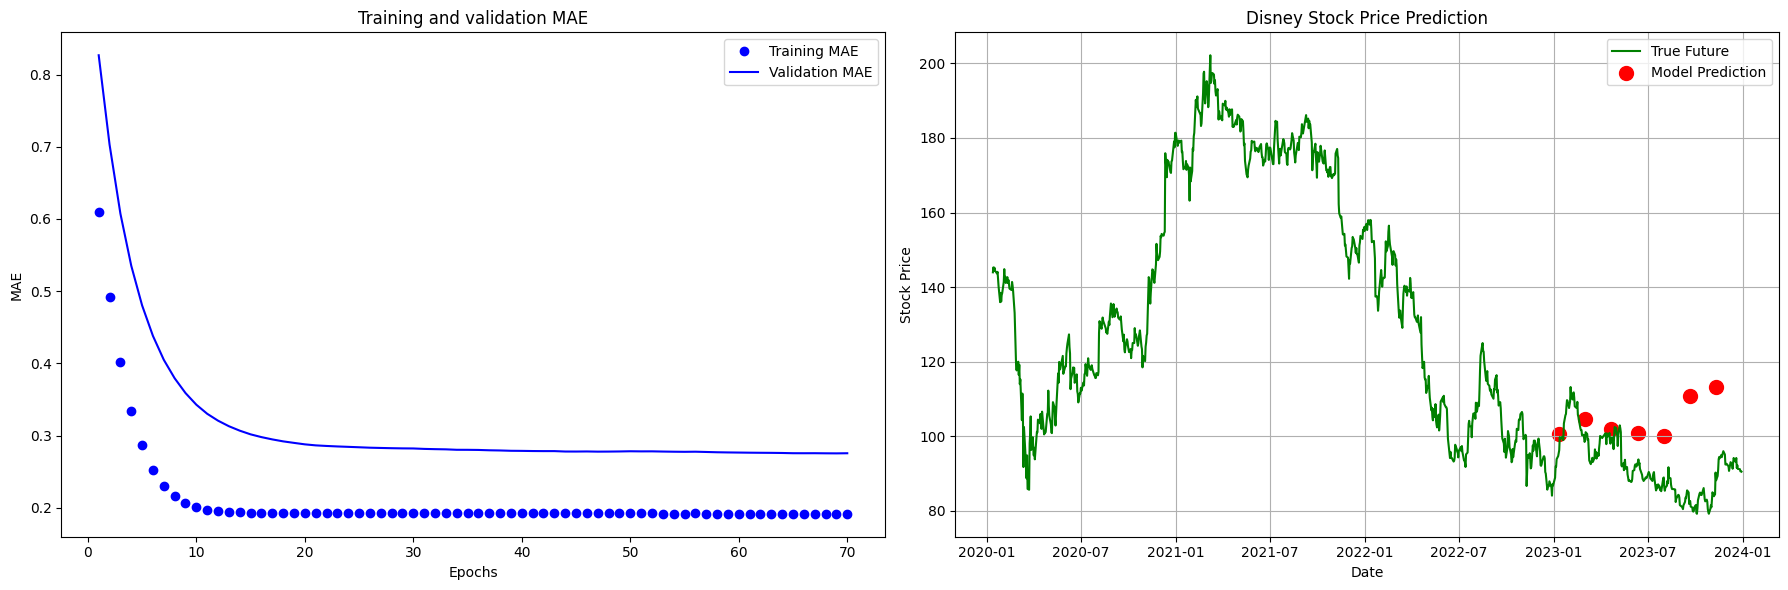

In [40]:
predictions = model.predict(test_dataset)

predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 7)  
axs[1].scatter(raw_data.index[-len(predictions):][prediction_indices], 
            predictions[prediction_indices], 
            label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Deep RNN**

In [42]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.SimpleRNN(13, return_sequences=True)(inputs)
x = layers.SimpleRNN(13, return_sequences=True)(x)
outputs = layers.SimpleRNN(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("disney_deep_rnn.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=70,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("disney_deep_rnn.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/70
2/2 [==============================] - 4s 685ms/step - loss: 0.6526 - mae: 0.7192 - val_loss: 1.1405 - val_mae: 0.9578
Epoch 2/70
2/2 [==============================] - 0s 108ms/step - loss: 0.4650 - mae: 0.5983 - val_loss: 0.9648 - val_mae: 0.8763
Epoch 3/70
2/2 [==============================] - 0s 123ms/step - loss: 0.3762 - mae: 0.5313 - val_loss: 0.8633 - val_mae: 0.8259
Epoch 4/70
2/2 [==============================] - 0s 122ms/step - loss: 0.3202 - mae: 0.4837 - val_loss: 0.7880 - val_mae: 0.7858
Epoch 5/70
2/2 [==============================] - 0s 121ms/step - loss: 0.2806 - mae: 0.4470 - val_loss: 0.7331 - val_mae: 0.7559
Epoch 6/70
2/2 [==============================] - 0s 112ms/step - loss: 0.2513 - mae: 0.4181 - val_loss: 0.6903 - val_mae: 0.7320
Epoch 7/70
2/2 [==============================] - 0s 136ms/step - loss: 0.2282 - mae: 0.3934 - val_loss: 0.6569 - val_mae: 0.7129
Epoch 8/70
2/2 [==============================] - 0s 120ms/step - loss: 0.2101 - mae: 0.37

1/1 [==============================] - 1s 578ms/step


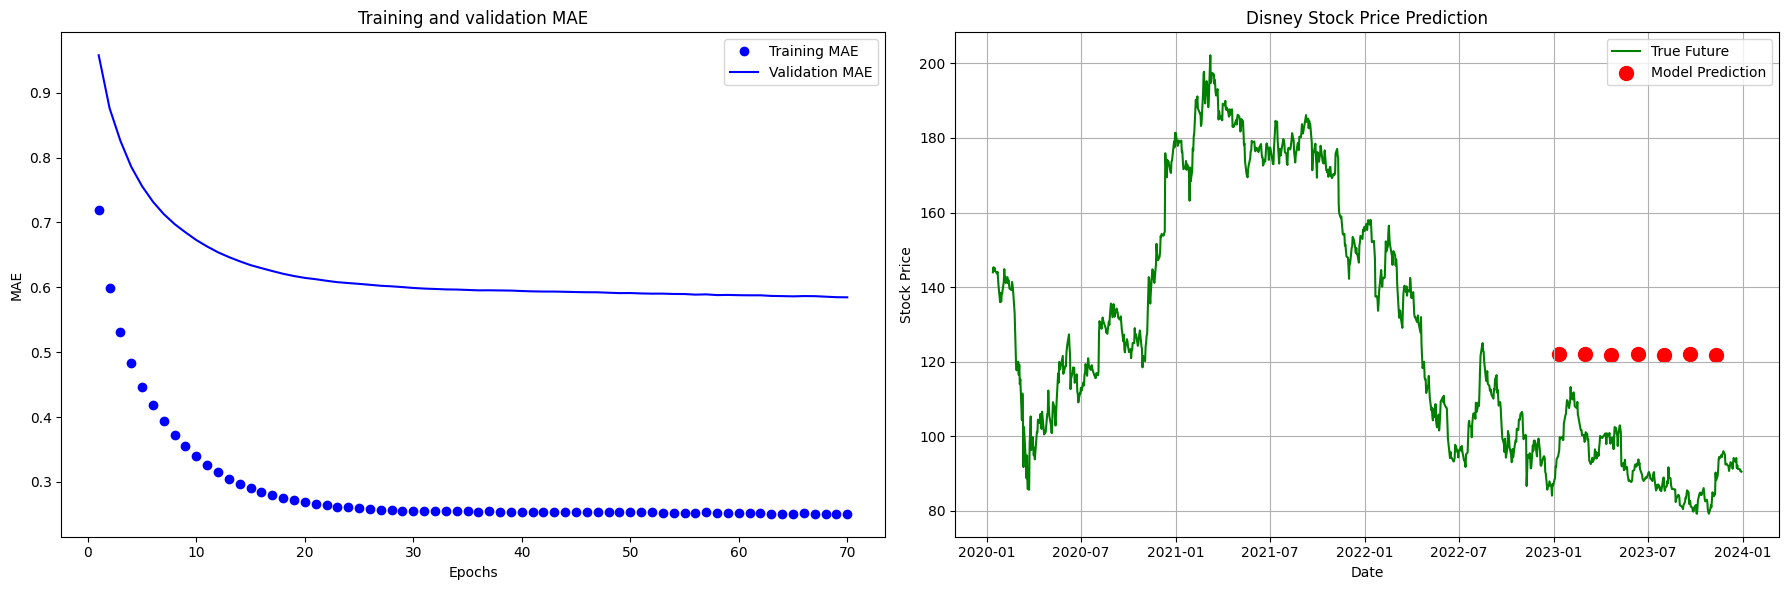

In [43]:
predictions = model.predict(test_dataset)

predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 7)  
axs[1].scatter(raw_data.index[-len(predictions):][prediction_indices], 
            predictions[prediction_indices], 
            label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Stacked GRU model**

In [44]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.3, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.3)(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("Disney_stacked_gru_dropout.keras", save_best_only=True)
]

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=80,   # Adjust epoch as needed
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("Disney_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/80
2/2 [==============================] - 6s 878ms/step - loss: 0.9503 - mae: 0.8718 - val_loss: 1.8800 - val_mae: 1.2270
Epoch 2/80
2/2 [==============================] - 0s 121ms/step - loss: 0.8902 - mae: 0.8444 - val_loss: 1.7729 - val_mae: 1.1920
Epoch 3/80
2/2 [==============================] - 0s 125ms/step - loss: 0.8422 - mae: 0.8199 - val_loss: 1.6707 - val_mae: 1.1577
Epoch 4/80
2/2 [==============================] - 0s 126ms/step - loss: 0.7912 - mae: 0.7930 - val_loss: 1.5658 - val_mae: 1.1211
Epoch 5/80
2/2 [==============================] - 0s 121ms/step - loss: 0.7430 - mae: 0.7671 - val_loss: 1.4617 - val_mae: 1.0835
Epoch 6/80
2/2 [==============================] - 0s 120ms/step - loss: 0.6924 - mae: 0.7404 - val_loss: 1.3595 - val_mae: 1.0454
Epoch 7/80
2/2 [==============================] - 0s 126ms/step - loss: 0.6462 - mae: 0.7119 - val_loss: 1.2582 - val_mae: 1.0060
Epoch 8/80
2/2 [==============================] - 0s 118ms/step - loss: 0.6011 - mae: 0.68

1/1 [==============================] - 1s 829ms/step


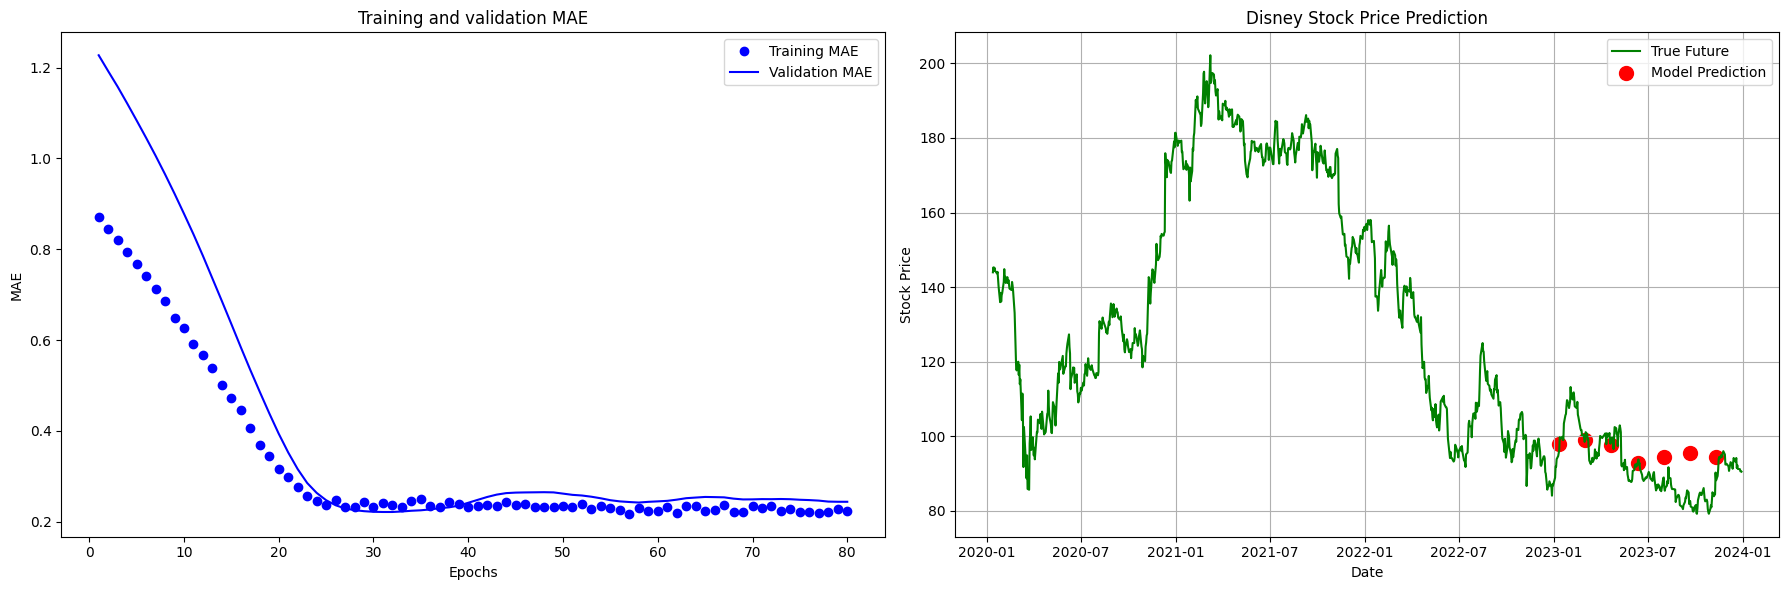

In [45]:
predictions = model.predict(test_dataset)

predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 7) 
axs[1].scatter(raw_data.index[-len(predictions):][prediction_indices], 
            predictions[prediction_indices], 
            label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Bidirectional RNNs** (Specifically LSTM)

In [46]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(14))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("Disney_bidirect_rnn.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=80,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("Disney_bidirect_rnn.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/80
2/2 [==============================] - 6s 1s/step - loss: 1.1692 - mae: 0.9714 - val_loss: 2.3317 - val_mae: 1.3654
Epoch 2/80
2/2 [==============================] - 0s 126ms/step - loss: 1.1423 - mae: 0.9601 - val_loss: 2.2784 - val_mae: 1.3500
Epoch 3/80
2/2 [==============================] - 0s 119ms/step - loss: 1.1168 - mae: 0.9490 - val_loss: 2.2233 - val_mae: 1.3339
Epoch 4/80
2/2 [==============================] - 0s 138ms/step - loss: 1.0915 - mae: 0.9380 - val_loss: 2.1703 - val_mae: 1.3182
Epoch 5/80
2/2 [==============================] - 0s 121ms/step - loss: 1.0665 - mae: 0.9271 - val_loss: 2.1178 - val_mae: 1.3025
Epoch 6/80
2/2 [==============================] - 0s 117ms/step - loss: 1.0417 - mae: 0.9161 - val_loss: 2.0671 - val_mae: 1.2871
Epoch 7/80
2/2 [==============================] - 0s 120ms/step - loss: 1.0181 - mae: 0.9055 - val_loss: 2.0178 - val_mae: 1.2720
Epoch 8/80
2/2 [==============================] - 0s 118ms/step - loss: 0.9945 - mae: 0.8948 

1/1 [==============================] - 2s 2s/step


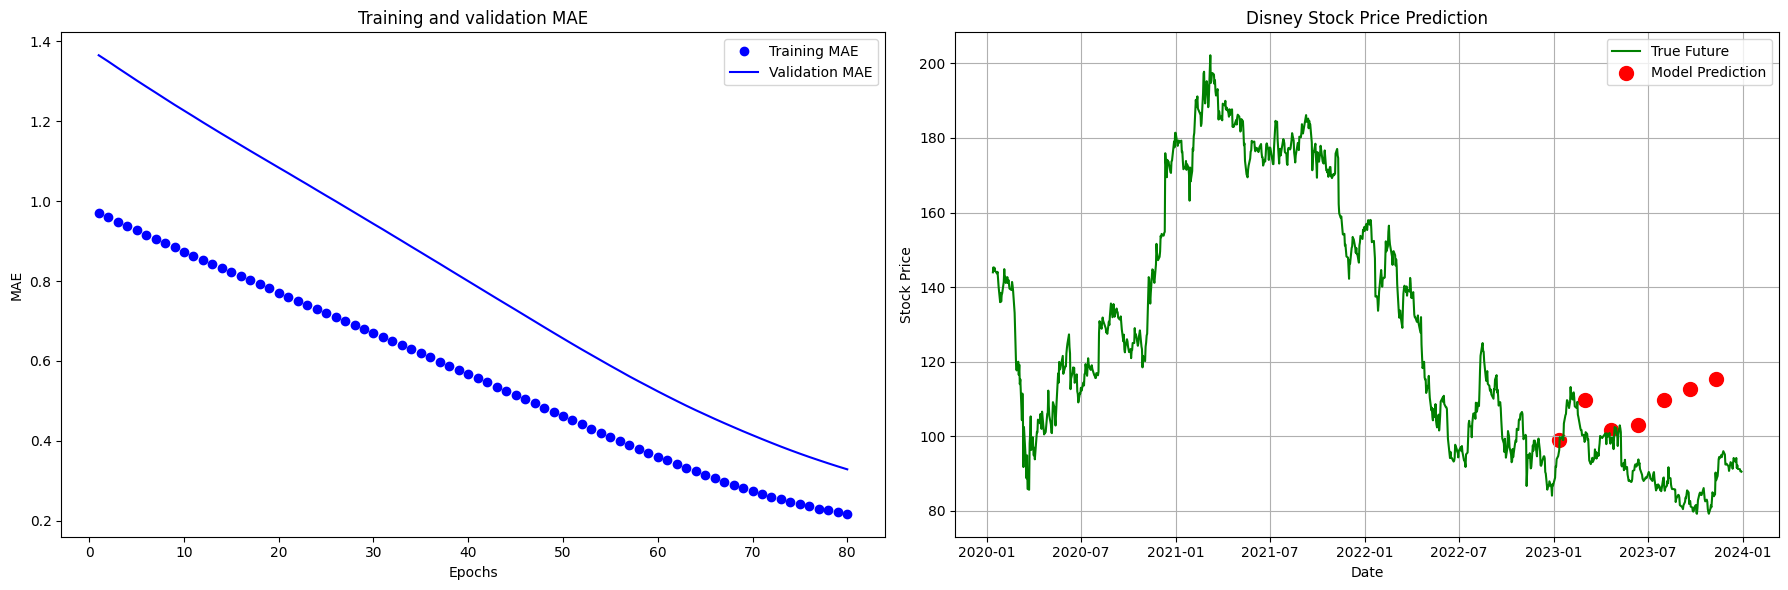

In [47]:
predictions = model.predict(test_dataset)

predictions = predictions * std.iloc[0] + mean.iloc[0]
actual_values = raw_data["adjclose"].iloc[delay:] * std.iloc[0] + mean.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

axs[1].plot(raw_data.index[-len(actual_values):], actual_values, label='True Future', color='green')
prediction_indices = range(0, len(predictions), len(predictions) // 7)  
axs[1].scatter(raw_data.index[-len(predictions):][prediction_indices], 
            predictions[prediction_indices], 
            label='Model Prediction', color='red', marker='o', s=100)
axs[1].set_title('Disney Stock Price Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Part C

In [4]:
np.random.seed(42)
random.set_seed(42)

def retrieve_stock_returns_data(ticker, start, end):
    json_data = YahooFinancials(ticker).get_historical_price_data(start, end, "daily")
    df = pd.DataFrame(columns=["open", "close", "adjclose"])
    for row in json_data[ticker]["prices"]:
        date = datetime.fromisoformat(row["formatted_date"])
        df.loc[date] = [row["open"], row["close"], row["adjclose"]]
    df.index.name = "date"
    returns = df['adjclose'].pct_change()
    return returns.dropna()

Disney_returns = retrieve_stock_returns_data('DIS', '2020-01-01', '2024-01-01')


num_train_samples = int(0.5 * len(Disney_returns))
num_val_samples = int(0.25 * len(Disney_returns))
num_test_samples = len(Disney_returns) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

mean = Disney_returns[:num_train_samples].mean(axis=0)
std = Disney_returns[:num_train_samples].std(axis=0)
Disney_returns -= mean
Disney_returns /= std

sampling_rate = 1
sequence_length = 1
future = 1
delay = sampling_rate * (sequence_length + future - 1)
batch_size = 256

raw_data = Disney_returns.values

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=raw_data[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=raw_data[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=raw_data[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

num_train_samples: 502
num_val_samples: 251
num_test_samples: 252


**Models**

**Basic Machine Learning Model**

In [45]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length,))
x = layers.Flatten()(inputs)
x = layers.Dense(14, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("disney_dense.keras", save_best_only=True)
]
model.compile(optimizer="sgd", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=80,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("disney_dense.keras")

test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/80
2/2 [==============================] - 0s 177ms/step - loss: 1.0418 - mae: 0.6697 - val_loss: 1.1176 - val_mae: 0.8201
Epoch 2/80
2/2 [==============================] - 0s 110ms/step - loss: 1.0360 - mae: 0.6671 - val_loss: 1.1093 - val_mae: 0.8168
Epoch 3/80
2/2 [==============================] - 0s 42ms/step - loss: 1.0318 - mae: 0.6650 - val_loss: 1.1020 - val_mae: 0.8139
Epoch 4/80
2/2 [==============================] - 0s 43ms/step - loss: 1.0273 - mae: 0.6631 - val_loss: 1.0950 - val_mae: 0.8112
Epoch 5/80
2/2 [==============================] - 0s 42ms/step - loss: 1.0238 - mae: 0.6614 - val_loss: 1.0884 - val_mae: 0.8085
Epoch 6/80
2/2 [==============================] - 0s 41ms/step - loss: 1.0199 - mae: 0.6596 - val_loss: 1.0825 - val_mae: 0.8062
Epoch 7/80
2/2 [==============================] - 0s 42ms/step - loss: 1.0165 - mae: 0.6582 - val_loss: 1.0768 - val_mae: 0.8040
Epoch 8/80
2/2 [==============================] - 0s 42ms/step - loss: 1.0132 - mae: 0.6568 - v

1/1 [==============================] - 0s 85ms/step


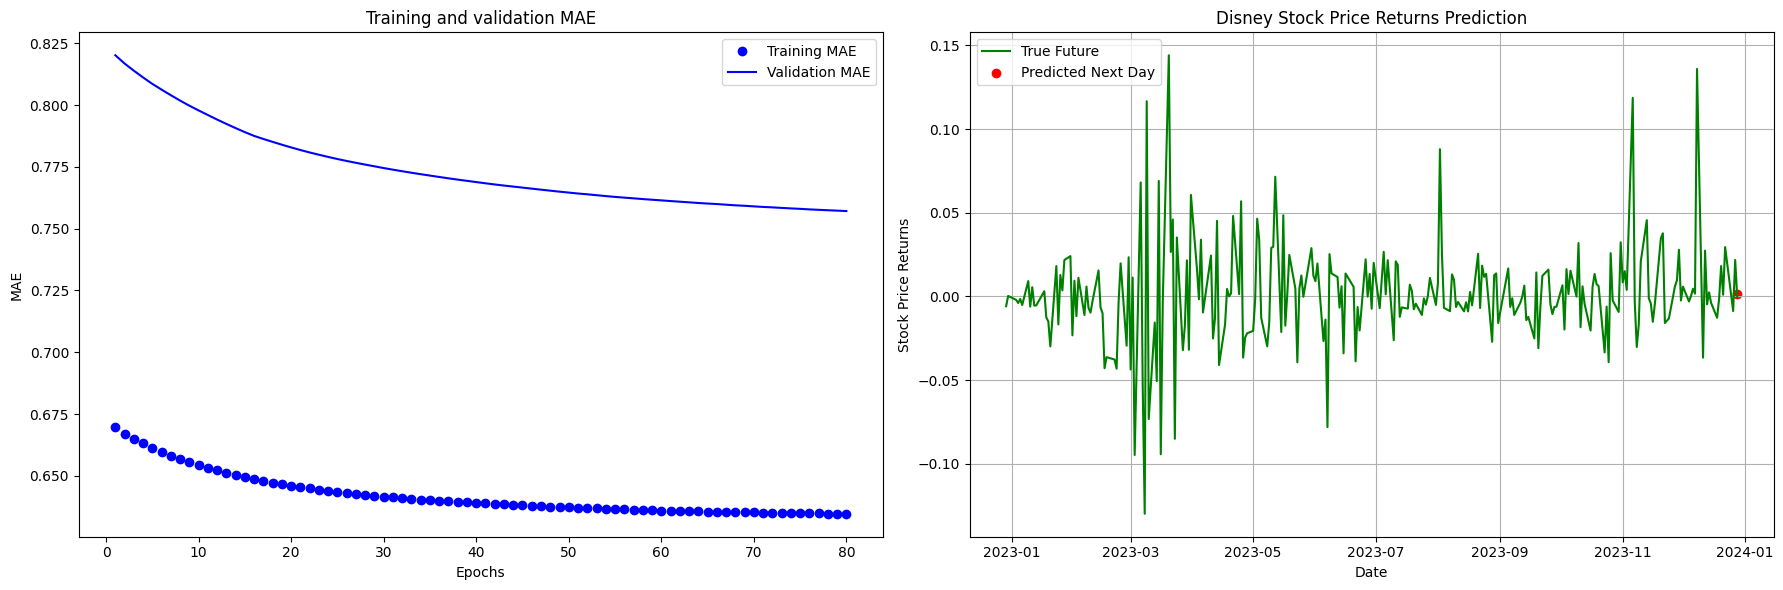

In [46]:
import matplotlib.pyplot as plt

predictions = model.predict(test_dataset)
predictions = predictions * std + mean 

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

# Plotting actual returns
actual_dates = Disney_returns.index[-len(predictions) - delay:-delay]
axs[1].plot(actual_dates, actual_values[:len(actual_dates)], label='True Future', color='green')

next_day_index = -1  
prediction_index = len(predictions) - 1 
axs[1].scatter(actual_dates[next_day_index], predictions[prediction_index], label='Predicted Next Day', color='red', marker='o')

axs[1].set_title('Disney Stock Price Returns Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price Returns')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()




**Linear**

In [49]:
inputs = keras.Input(shape=(sequence_length,))
x = layers.Flatten()(inputs) 
x = layers.Dense(14, activation='relu')(x)  
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("disney_linear.keras", save_best_only=True)
]

model.compile(optimizer="sgd", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=80, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("disney_linear.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/80
2/2 [==============================] - 0s 93ms/step - loss: 1.0737 - mae: 0.6795 - val_loss: 1.1889 - val_mae: 0.8443
Epoch 2/80
2/2 [==============================] - 0s 66ms/step - loss: 1.0615 - mae: 0.6741 - val_loss: 1.1667 - val_mae: 0.8363
Epoch 3/80
2/2 [==============================] - 0s 41ms/step - loss: 1.0513 - mae: 0.6694 - val_loss: 1.1478 - val_mae: 0.8294
Epoch 4/80
2/2 [==============================] - 0s 43ms/step - loss: 1.0408 - mae: 0.6654 - val_loss: 1.1306 - val_mae: 0.8229
Epoch 5/80
2/2 [==============================] - 0s 40ms/step - loss: 1.0328 - mae: 0.6620 - val_loss: 1.1147 - val_mae: 0.8170
Epoch 6/80
2/2 [==============================] - 0s 42ms/step - loss: 1.0251 - mae: 0.6587 - val_loss: 1.1008 - val_mae: 0.8119
Epoch 7/80
2/2 [==============================] - 0s 45ms/step - loss: 1.0186 - mae: 0.6558 - val_loss: 1.0880 - val_mae: 0.8072
Epoch 8/80
2/2 [==============================] - 0s 41ms/step - loss: 1.0128 - mae: 0.6535 - val

1/1 [==============================] - 0s 58ms/step


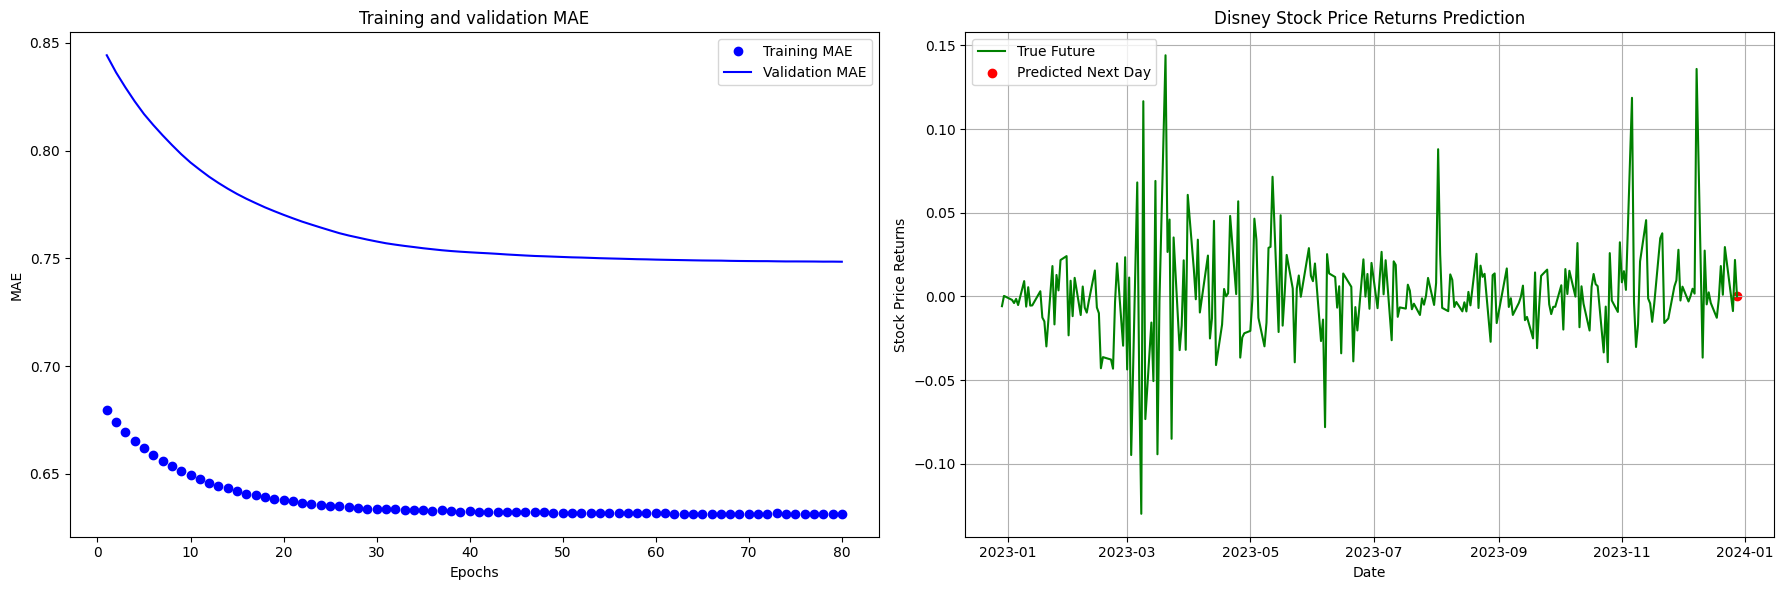

In [50]:
predictions = model.predict(test_dataset)
predictions = predictions * std + mean 

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training MAE")
axs[0].plot(epochs, val_loss, "b", label="Validation MAE")
axs[0].set_title("Training and validation MAE")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MAE")
axs[0].legend()

actual_dates = Disney_returns.index[-len(predictions) - delay:-delay]
axs[1].plot(actual_dates, actual_values[:len(actual_dates)], label='True Future', color='green')
prediction_index = len(predictions) - 1  
axs[1].scatter(actual_dates[next_day_index], predictions[prediction_index], label='Predicted Next Day', color='red', marker='o')
axs[1].set_title('Disney Stock Price Returns Prediction')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock Price Returns')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


**A simple LSTM-based model** (A first recurent baseline)

In [51]:
inputs = keras.Input(shape=(sequence_length,))
x = layers.LSTM(14)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("disney_lstm.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=70,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("disney_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

ValueError: Input 0 of layer "lstm_8" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1)

It seems that for the red of the models I seem to be running on a dimension error. I tried to fix that but for some reason I was not able to fix it. The problem should be on how I calculate the stock returns. It seems to be a little bit more complicated based on some articles I read on the internet from what I have thought or what others may have done.

__________________________________________________________________________________________________________________________